The data used for this project "MOVIE RECOMMENDATION SYSTEM" is from Kaggle (open source platform), containing information about movie datasets and user ratings.

The 'links_small.csv' dataset contains mapping information between movie IDs, IMDb IDs, and TMDb IDs.

The 'ratings_small.csv' dataset includes user ratings for various movies, with columns for user ID, movie ID, rating, and timestamp.

The 'movies_metadata.csv' the main Movies Metadata file contains data on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

The 'keywords.csv' Contains the movie plot keywords for our MovieLens movies.

credits.csv: Consists of Cast and Crew Information for all our movies.

links.csv: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast as ast
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

In [ ]:
!pip install numpy pandas faiss-cpu requests


# Data Preprocessing

In [ ]:
#Load the data from cvs file

movie_metadata = pd.read_csv("/content/drive/My Drive/dataset/movies_metadata.csv")
# Strip any leading or trailing whitespace from column names
movie_metadata.columns = movie_metadata.columns.str.strip()

print(movie_metadata.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


<ipython-input-3-c2e4b2eb1a18>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv("/content/drive/My Drive/dataset/movies_metadata.csv")


In [ ]:
movie_metadata.head(10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
7,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0
8,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0


In [ ]:
ratings = pd.read_csv("/content/drive/My Drive/dataset/ratings_small.csv")
ratings.columns = ratings.columns.str.strip()

credits = pd.read_csv("/content/drive/My Drive/dataset/credits.csv")[['id','cast']]
credits.columns = credits.columns.str.strip()

links = pd.read_csv("/content/drive/My Drive/dataset/links.csv")
links.columns = links.columns.str.strip()

keywords = pd.read_csv("/content/drive/My Drive/dataset/keywords.csv")

In [ ]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
links.head(10)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
5,6,113277,949.0
6,7,114319,11860.0
7,8,112302,45325.0
8,9,114576,9091.0
9,10,113189,710.0


In [ ]:
credits.head(10)

,id,cast
0,862,"[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah..."
4,11862,"[{'cast_id': 1, 'character': 'George Banks', '..."
5,949,"[{'cast_id': 25, 'character': 'Lt. Vincent Han..."
6,11860,"[{'cast_id': 1, 'character': 'Linus Larrabee',..."
7,45325,"[{'cast_id': 2, 'character': 'Tom Sawyer', 'cr..."
8,9091,"[{'cast_id': 1, 'character': 'Darren Francis T..."
9,710,"[{'cast_id': 1, 'character': 'James Bond', 'cr..."


In [ ]:
# Checking for missing values in links,ratings and movie metadata
links_null_values = links.isnull().sum()
ratings_null_values = ratings.isnull().sum()
movie_metadata_null_values = movie_metadata.isnull().sum()
# Display the columns with missing values and their counts
links_null_values


,0
movieId,0
imdbId,0
tmdbId,219


In [ ]:

# Replace missing 'tmdbId' values with 0 inplace of missing values
links['tmdbId'].fillna(0, inplace=True)
movie_metadata = movie_metadata[movie_metadata['id'].str.isnumeric()] # Removing the records for which the id is not available

<ipython-input-8-dbc0de25a61c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  links['tmdbId'].fillna(0, inplace=True)


In [ ]:
#check whether we still have any missing values after replacing the missing values
links_null_values = links.isnull().sum()
links_null_values

,0
movieId,0
imdbId,0
tmdbId,0


In [ ]:
ratings_null_values

,0
userId,0
movieId,0
rating,0
timestamp,0


In [ ]:
movie_metadata_null_values

,0
adult,0
belongs_to_collection,40972
budget,0
genres,0
homepage,37684
id,0
imdb_id,17
original_language,11
original_title,0
overview,954


In [ ]:
movie_metadata['runtime'].fillna(0, inplace=True)
movie_metadata['imdb_id'].fillna("Nan",inplace=True)
movie_metadata['homepage'].fillna(0,)
movie_metadata['belongs_to_collection'].fillna('No Collection', inplace=True)


<ipython-input-12-3e58b5f0f61b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_metadata['runtime'].fillna(0, inplace=True)
<ipython-input-12-3e58b5f0f61b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [ ]:
movie_metadata['release_date'] = pd.to_datetime(movie_metadata['release_date'], errors='coerce')


In [ ]:
# Dropping columns with high null counts
columns_to_drop = ['belongs_to_collection', 'homepage', 'tagline']
movie_metadata.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Fill categorical columns with placeholder
movie_metadata['imdb_id'].fillna('Unknown', inplace=True)
movie_metadata['original_language'].fillna('Unknown', inplace=True)
movie_metadata['overview'].fillna('No Overview', inplace=True)
movie_metadata['status'].fillna('Unknown', inplace=True)
movie_metadata.dropna(subset=['status'], inplace=True)
movie_metadata.dropna(subset=['poster_path'], inplace=True)

# Fill numeric columns with appropriate values
movie_metadata['popularity'].fillna(0, inplace=True)
movie_metadata['revenue'].fillna(movie_metadata['revenue'].median(), inplace=True)
movie_metadata['runtime'].fillna(movie_metadata['runtime'].median(), inplace=True)

# Dropping rows where essential columns have null values
essential_columns = ['release_date', 'vote_average', 'vote_count']
movie_metadata.dropna(subset=essential_columns, inplace=True)

# Display the cleaned DataFrame
print(movie_metadata.head())

   adult    budget                                             genres     id  \
0  False  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...    862   
1  False  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   8844   
2  False         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  15602   
3  False  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  31357   
4  False         0                     [{'id': 35, 'name': 'Comedy'}]  11862   

     imdb_id original_language               original_title  \
0  tt0114709                en                    Toy Story   
1  tt0113497                en                      Jumanji   
2  tt0113228                en             Grumpier Old Men   
3  tt0114885                en            Waiting to Exhale   
4  tt0113041                en  Father of the Bride Part II   

                                            overview popularity  \
0  Led by Woody, Andy's toys live happily in his ...  21.946943   
1  Whe

<ipython-input-15-71928d3faaa1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_metadata['imdb_id'].fillna('Unknown', inplace=True)
<ipython-input-15-71928d3faaa1>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [ ]:
movie_metadata[:10]

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0
5,False,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,False,7.7,1886.0
6,False,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,...,"[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,Sabrina,False,6.2,141.0
7,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",2.561161,/sGO5Qa55p7wTu7FJcX4H4xIVKvS.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Tom and Huck,False,5.4,45.0
8,False,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,5.23158,/eoWvKD60lT95Ss1MYNgVExpo5iU.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sudden Death,False,5.5,174.0
9,False,58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,/5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg,...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,GoldenEye,False,6.6,1194.0


In [ ]:
movie_metadata_null_values = movie_metadata.isnull().sum()

In [ ]:
movie_metadata_null_values

,0
adult,0
budget,0
genres,0
id,0
imdb_id,0
original_language,0
original_title,0
overview,0
popularity,0
poster_path,0


In [ ]:
movie_metadata['release_date'] = pd.to_datetime(movie_metadata['release_date'], errors='coerce')

In [ ]:
# Extract year
if 'release_date' in movie_metadata.columns:
    movie_metadata['year'] = movie_metadata['release_date'].dt.year
else:
    print("The 'release_date' column does not exist in the DataFrame.")

# Display the first few rows to confirm
print(movie_metadata[['release_date', 'year']].head())

  release_date  year
0   1995-10-30  1995
1   1995-12-15  1995
2   1995-12-22  1995
3   1995-12-22  1995
4   1995-02-10  1995


In [ ]:
movie_metadata['year'] = movie_metadata['release_date'].dt.year

In [ ]:
movie_metadata['year'].value_counts().sort_index()

,count
year,
1874,1
1878,1
1883,1
1887,1
1888,2
...,...
2015,1897
2016,1596
2017,530


In [ ]:
movie_metadata['genres'] = movie_metadata['genres'].str.replace('|', ' ')

In [ ]:
movie_metadata['original_title'] = movie_metadata['original_title'].str.lower()

In [ ]:
# removing the null terminating char at the end
movie_metadata['movie_title'] = movie_metadata['original_title'].apply(lambda x : x[:len(x)])

In [ ]:
movie_metadata['movie_title'][1]

'jumanji'

In [ ]:
movie_metadata['id'] = movie_metadata['id'].astype(int)

In [ ]:
movie_metadata.to_csv('movie_dataset.csv',index=False)

In [ ]:
movie_data = pd.merge(movie_metadata, credits, on='id')

In [ ]:
pd.set_option('display.max_colwidth', 100)
movie_data

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,runtime,spoken_languages,status,title,video,vote_average,vote_count,year,movie_title,cast
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",862,tt0114709,en,toy story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear o...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,1995,toy story,"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender'..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",8844,tt0113497,en,jumanji,When siblings Judy and Peter discover an enchanted board game that opens the door to a magical w...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Jumanji,False,6.9,2413.0,1995,jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', 'credit_id': '52fe44bfc3a36847f80a7c73', 'gender': ..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",15602,tt0113228,en,grumpier old men,A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,1995,grumpier old men,"[{'cast_id': 2, 'character': 'Max Goldman', 'credit_id': '52fe466a9251416c75077a8d', 'gender': 2..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",31357,tt0114885,en,waiting to exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusi...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0,1995,waiting to exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah' Jackson"", 'credit_id': '52fe44779251416c91011aad..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,father of the bride part ii,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she'...",8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,1995,father of the bride part ii,"[{'cast_id': 1, 'character': 'George Banks', 'credit_id': '52fe44959251416c75039eb9', 'gender': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45107,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name': 'Action'}, {'id': 10749, 'name': 'Romance'}]",30840,tt0102797,en,robin hood,"Yet another version of the classic epic, with enough variation to make it interesting. The story...",5.683753,/fQC46NglNiEMZBv5XHoyLuOWoN5.jpg,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Robin Hood,False,5.7,26.0,1991,robin hood,"[{'cast_id': 1, 'character': 'Sir Robert Hode', 'credit_id': '52fe44439251416c9100a887', 'gender..."
45108,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tt2028550,tl,siglo ng pagluluwal,An artist struggles to finish his work while a storyline about a cult plays in his head.,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,...,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,Century of Birthing,False,9.0,3.0,2011,siglo ng pagluluwal,"[{'cast_id': 1002, 'character': 'Sister Angela', 'credit_id': '52fe4af1c3a36847f81e9b1f', 'gende..."
45109,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]",67758,tt0303758,en,betrayal,"When one of her hits goes wrong, a professional assassin ends up with a suitcase full of a milli...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,...,90.0,"[{'iso_639_1': 'en', 'n

In [ ]:
import ast
import json

def safe_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            try:
                return json.loads(x.replace("'", '"'))
            except:
                return []
    return x

movie_data['genres'] = movie_data['genres'].apply(safe_eval)
movie_data['cast'] = movie_data['cast'].apply(safe_eval)

In [ ]:
print(movie_data['genres'][0])

[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]


In [ ]:
def format_genre_list(x):
    gen = []
    st = " "
    for i in x:
        if i.get('name') == 'Science Fiction':
            scifi = 'Sci-Fi'
            gen.append(scifi)
        else:
            gen.append(i.get('name'))
    if gen == []:
        return np.nan
    else:
        return (st.join(gen))

In [ ]:
movie_data['genres_list'] = movie_data['genres'].map(lambda x: format_genre_list(x))
movie_data['genres_list']

,genres_list
0,Animation Comedy Family
1,Adventure Fantasy Family
2,Romance Comedy
3,Comedy Drama Romance
4,Comedy
...,...
45107,Drama Action Romance
45108,Drama
45109,Action Drama Thriller
45110,NaN


In [ ]:
movie_data.isna().sum()

,0
adult,0
budget,0
genres,0
id,0
imdb_id,0
original_language,0
original_title,0
overview,0
popularity,0
poster_path,0


In [ ]:
movie_data.to_csv('/content/drive/My Drive/dataset/prepocessed_movie_dataset.csv',index=False)

# EXPLORATORY DATA ANALYSIS

# 1. Visualize the Number of Movies Released Each Year
You can create a bar plot to show the number of movies released each year.

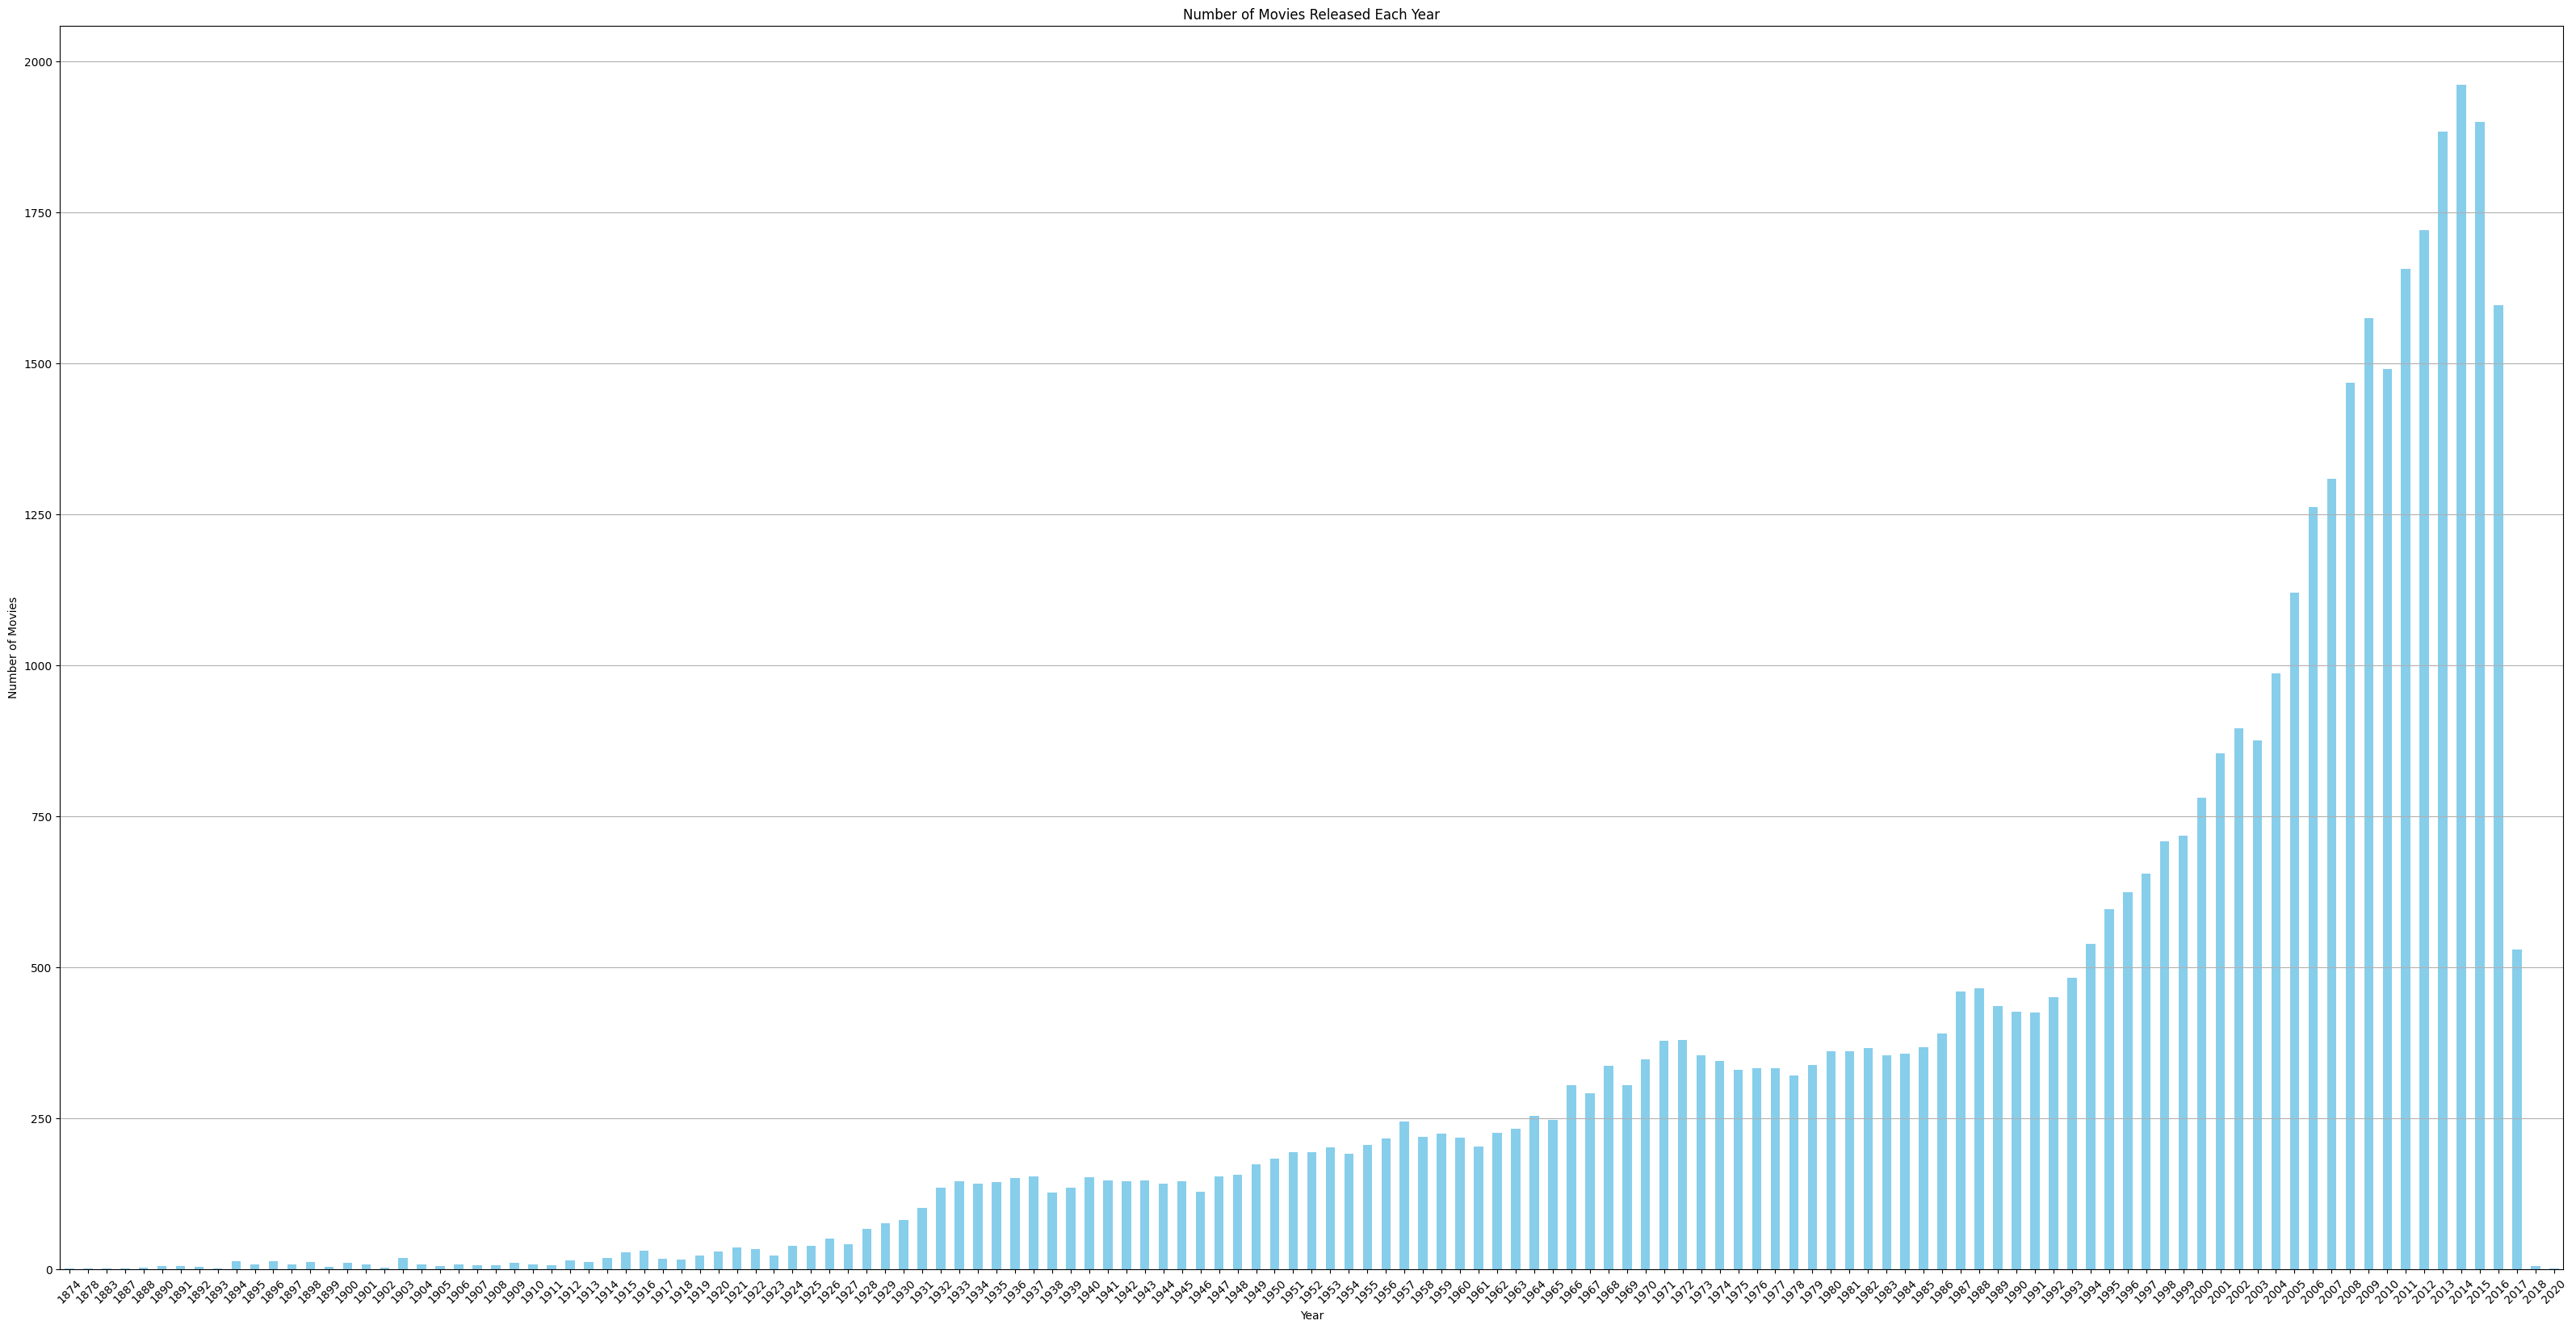

In [ ]:
import matplotlib.pyplot as plt

# Count the number of movies released each year
movies_per_year = movie_data['year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(40, 20))
movies_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

 # **Correlation Heatmap**

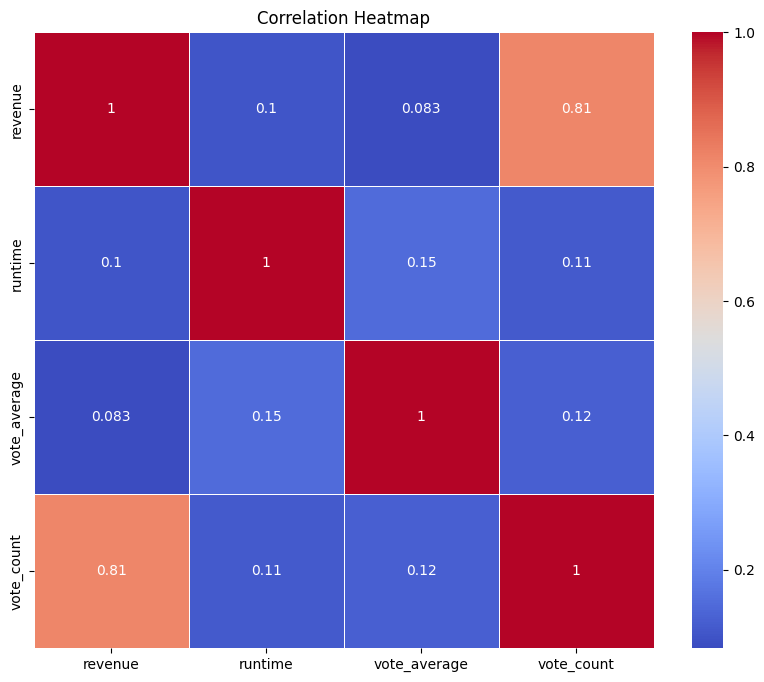

In [ ]:
# Updated numerical columns without 'popularity'
numerical_cols = ['revenue', 'runtime', 'vote_average', 'vote_count']

# Generate the correlation matrix
correlation_matrix = movie_data[numerical_cols].corr()

# Plotting the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Genre Popularity Distribution

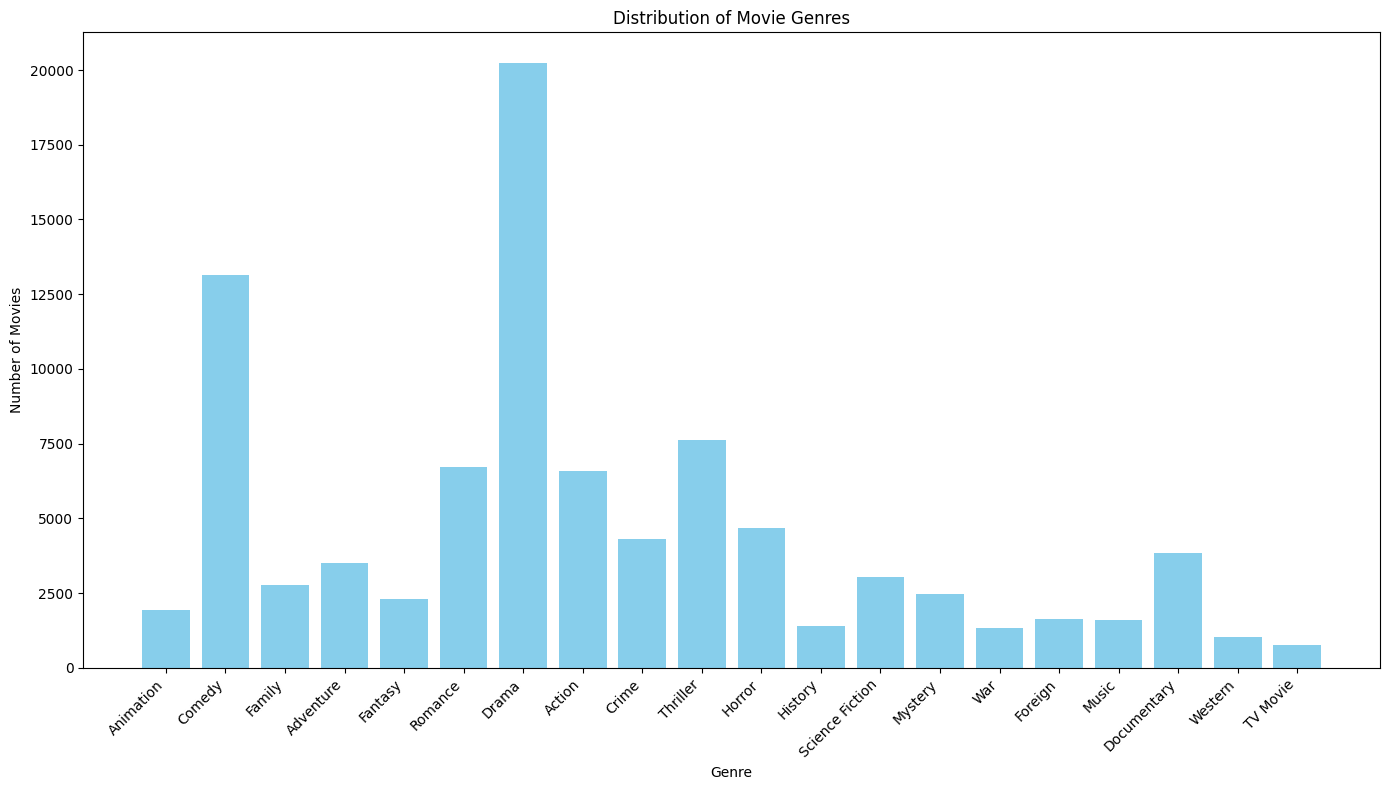

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval  # safer alternative to eval()
from collections import Counter

# Assuming movie_data is your DataFrame and 'genres' is the column of interest
# Fill NaN values with an empty list '[]'
movie_data['genres'] = movie_data['genres'].fillna('[]')

# Use literal_eval instead of eval to safely parse strings to Python objects
movie_data['genres'] = movie_data['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Extract genre names into 'genres_list'
movie_data['genres_list'] = movie_data['genres'].apply(lambda x: [genre['name'] for genre in x] if isinstance(x, list) else [])

# Flatten the list of all genres
all_genres = [genre for sublist in movie_data['genres_list'] for genre in sublist]

# Count occurrences of each genre
genre_counts = Counter(all_genres)

# Plot the genre counts
plt.figure(figsize=(14, 8))
plt.bar(genre_counts.keys(), genre_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()


# top 10 movies by revenue

<ipython-input-42-2923e998a617>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='revenue', y='original_title', data=top_revenue_movies, palette='viridis')


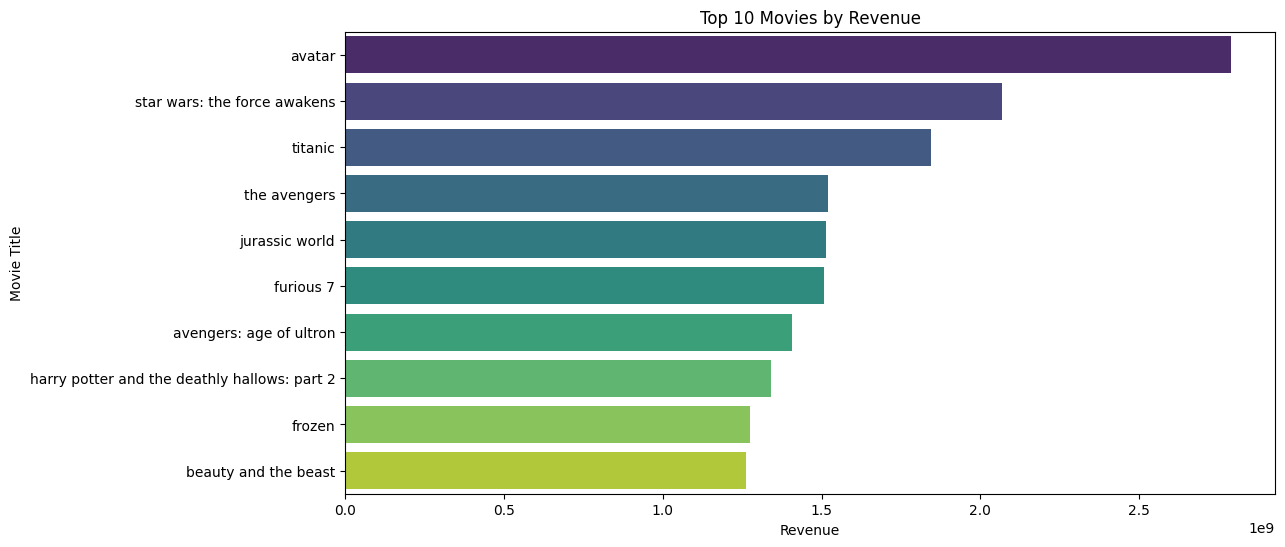

In [ ]:
top_revenue_movies = movie_data[['original_title', 'revenue']].sort_values(by='revenue', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='revenue', y='original_title', data=top_revenue_movies, palette='viridis')
plt.title('Top 10 Movies by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Movie Title')
plt.show()

 # Language Distribution

In [ ]:
# Mapping of language codes to their full names
language_mapping = {
    'en': 'English',
    'fr': 'French',
    'es': 'Spanish',
    'de': 'German',
    'it': 'Italian',
    'ja': 'Japanese',
    'zh': 'Chinese',
    'ko': 'Korean',
    'hi': 'Hindi',
    'ru': 'Russian',
    'pt': 'Portuguese',
    'ar': 'Arabic',
    'tr': 'Turkish',
    'nl': 'Dutch',
    'sv': 'Swedish',
    'no': 'Norwegian',
    'da': 'Danish',
    'fi': 'Finnish',
    'pl': 'Polish',
}

In [ ]:
# Replace language codes with full names using the mapping dictionary
movie_data['original_language_full'] = movie_data['original_language'].map(language_mapping).fillna(movie_data['original_language'])


<ipython-input-45-30f5def55846>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.index, y=language_counts.values, palette='rainbow')


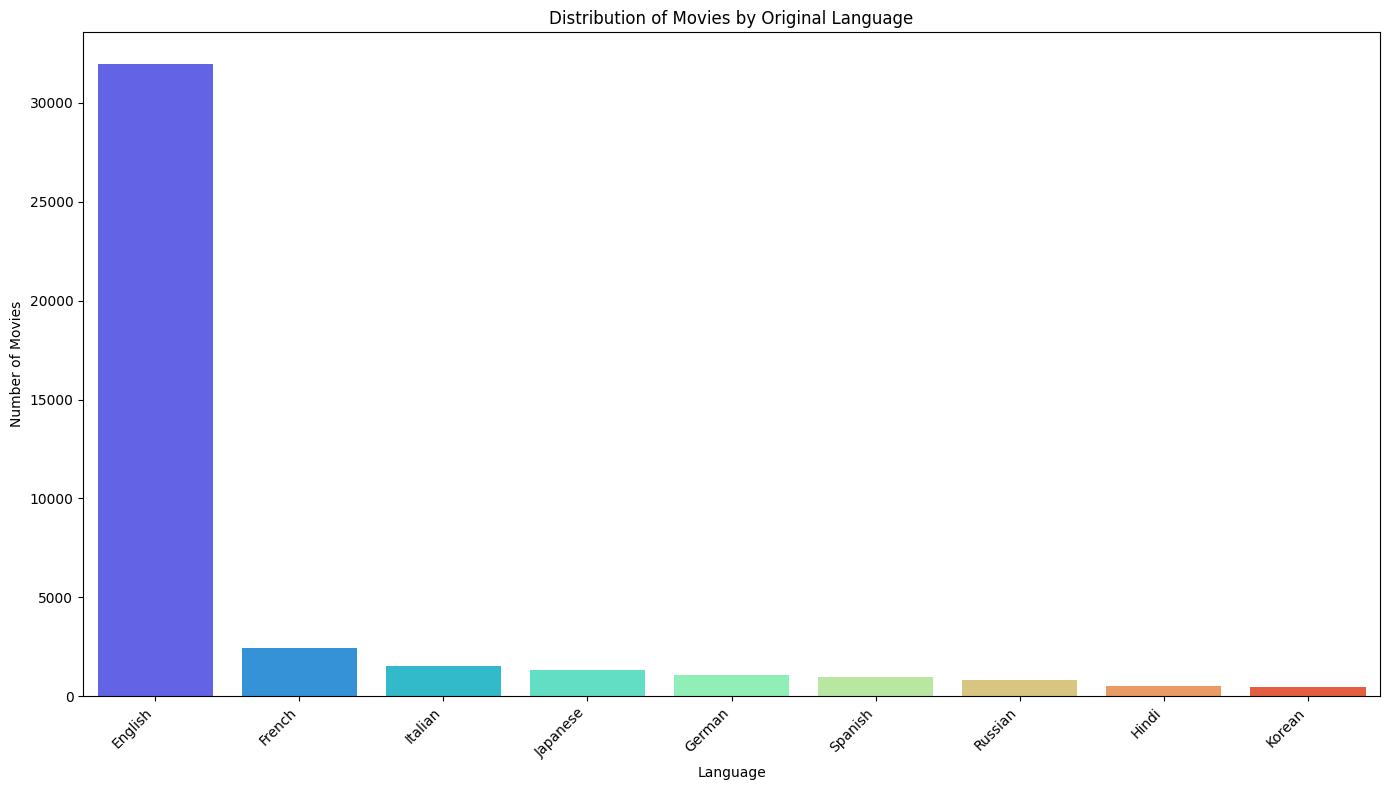

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each language
language_counts = movie_data['original_language_full'].value_counts().nlargest(9)

# Plot the distribution of movies by original language
plt.figure(figsize=(14, 8))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='rainbow')
plt.title('Distribution of Movies by Original Language')
plt.xlabel('Language')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# CONTENT BASED FILTERING

In [ ]:
movie_data['id'] = movie_data['id'].astype(int)
movie_data = movie_data[movie_data['vote_count']>=30]
movie_data = movie_data[['id','original_title','overview','genres','release_date','revenue','runtime','original_language', 'vote_count', 'vote_average']]
movie_data['title'] = movie_data['original_title'].copy()

#Making tags column
df = pd.merge(movie_data, keywords, on='id', how='left')
df = pd.merge(df, credits, on='id', how='left')
df.head()

,id,original_title,overview,genres,release_date,revenue,runtime,original_language,vote_count,vote_average,title,keywords,cast
0,862,toy story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear o...","[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",1995-10-30,373554033.0,81.0,en,5415.0,7.7,toy story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id...","[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender'..."
1,8844,jumanji,When siblings Judy and Peter discover an enchanted board game that opens the door to a magical w...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",1995-12-15,262797249.0,104.0,en,2413.0,6.9,jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 10941, 'name': 'disappearance'}, {'id': 15101, 'nam...","[{'cast_id': 1, 'character': 'Alan Parrish', 'credit_id': '52fe44bfc3a36847f80a7c73', 'gender': ..."
2,15602,grumpier old men,A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",1995-12-22,0.0,101.0,en,92.0,6.5,grumpier old men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392, 'name': 'best friend'}, {'id': 179431, 'name': '...","[{'cast_id': 2, 'character': 'Max Goldman', 'credit_id': '52fe466a9251416c75077a8d', 'gender': 2..."
3,31357,waiting to exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusi...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",1995-12-22,81452156.0,127.0,en,34.0,6.1,waiting to exhale,"[{'id': 818, 'name': 'based on novel'}, {'id': 10131, 'name': 'interracial relationship'}, {'id'...","[{'cast_id': 1, 'character': ""Savannah 'Vannah' Jackson"", 'credit_id': '52fe44779251416c91011aad..."
4,11862,father of the bride part ii,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she'...","[{'id': 35, 'name': 'Comedy'}]",1995-02-10,76578911.0,106.0,en,173.0,5.7,father of the bride part ii,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'name': 'midlife crisis'}, {'id': 2246, 'name': 'con...","[{'cast_id': 1, 'character': 'George Banks', 'credit_id': '52fe44959251416c75039eb9', 'gender': ..."


In [ ]:
df.shape

(12707, 13)

In [ ]:
import ast

# Check the data type and apply ast.literal_eval only when necessary
def safe_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(val, list):
        return val
    return []

df['genres'] = df['genres'].apply(safe_eval)
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x if isinstance(i, dict)])
df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))


# If the cast information is in another column, replace 'original_cast_column_name' with the actual name
df['cast'] = df['cast'].fillna('[]')
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)] if isinstance(x, str) else [])
df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))


# Now you can proceed with the rest of the code
df['tags'] = df['genres'] + ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']
df = df[["id", "title", "overview", "tags"]]
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)


<ipython-input-40-970c97de04eb>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-40-970c97de04eb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf = TfidfVectorizer(max_features=5000)
df['overview'] = df['overview'].astype(str)
vectorized_data = tfidf.fit_transform(df['overview'].values)
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=df['overview'].index.tolist())
svd = TruncatedSVD(n_components=3000)
reduced_data = svd.fit_transform(vectorized_dataframe)
df["overview"] = df["overview"].astype(object)
for i in range(len(df)):
    df["overview"].iloc[i]=reduced_data[i]
df.head(5)

In [ ]:
import joblib

In [ ]:
joblib.dump(reduced_data, '/content/drive/My Drive/dataset/reduced_data.pkl')

['/content/drive/My Drive/dataset/reduced_data.pkl']

In [ ]:
df.to_csv('/content/drive/My Drive/dataset/preprocessed_data_content_based.csv',index= False)

In [ ]:
reduced_data = joblib.load('/content/drive/My Drive/dataset/reduced_data.pkl')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_cosine = cosine_similarity(reduced_data)

joblib.dump(similarity_cosine, '/content/drive/My Drive/dataset/cosine_similarity.pkl')

print("Cosine similarity matrix saved.")


Cosine similarity matrix saved.


In [ ]:
def recommendation(movie_title):
    id_of_movie = df[df['title']==movie_title].index[0]

    similarity_cosine = joblib.load('/content/drive/My Drive/dataset/cosine_similarity.pkl')

    distances = similarity_cosine[id_of_movie]

    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:11]

    title_list=[]
    id_list=[]
    for i in movie_list:
        title_list.append(df.iloc[i[0]].title)
        id_list.append(df.iloc[i[0]].id)

    return(id_list, title_list)

In [ ]:
recommendation('toy story')[1]

['toy story 3',
 'toy story 2',
 'the 40 year old virgin',
 'man on the moon',
 'factory girl',
 'condorman',
 'class of 1984',
 '桃姐',
 'for love or money',
 'burke & hare']